In [35]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("yogitamakkar178/Dementia_audio")

In [36]:
ds

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 355
    })
})

In [37]:
train_data = ds['train']
print(f"Accessing the 'train' split which has {len(train_data)} samples.")

Accessing the 'train' split which has 355 samples.


In [38]:
# Get the first sample (index 0)
first_sample = train_data[0]
print("\nFirst sample:")
print(first_sample)


First sample:
{'audio': {'path': 'zip://dementia/Abe Burrows/AbeBurrows_5.wav::C:\\Users\\prach\\.cache\\huggingface\\hub\\datasets--yogitamakkar178--Dementia_audio\\snapshots\\7b907fc785a8987574df18872f39367a2162b9f7\\$RQQUVBT.zip', 'array': array([ 0.00097656,  0.00515747,  0.01370239, ..., -0.11019897,
       -0.11160278, -0.11077881]), 'sampling_rate': 44100}, 'label': 0}


In [39]:
import os
import numpy as np
import librosa
import soundfile as sf
from datasets import load_dataset
import collections

# --- Configuration ---
DATASET_ID = "yogitamakkar178/Dementia_audio"
OUTPUT_DIR = r"C:\Users\prach\Desktop\MemoTag\data" # Use raw string for Windows paths
NUM_SAMPLES_PER_GROUP = 5

# --- Define the *strings* we expect in the paths ---
# --- These might need adjustment if the actual folder names differ ---
CONTROL_PATH_LABEL = "nodementia"
DEMENTIA_PATH_LABEL = "dementia"
# --------------------------------------------------

TARGET_SR = 16000  # Target sampling rate (Hz) for saved audio

# --- Create Output Directory Structure ---
control_output_dir = os.path.join(OUTPUT_DIR, "Control")
dementia_output_dir = os.path.join(OUTPUT_DIR, "Dementia")
os.makedirs(control_output_dir, exist_ok=True)
os.makedirs(dementia_output_dir, exist_ok=True)
print(f"Output directories created/ensured exist at:")
print(f"- {control_output_dir}")
print(f"- {dementia_output_dir}")

# --- Load Hugging Face Dataset ---
try:
    print(f"\nLoading dataset '{DATASET_ID}' from Hugging Face...")
    ds = load_dataset(DATASET_ID)
    print("Dataset loaded successfully.")

    if 'train' not in ds:
        possible_splits = list(ds.keys())
        if possible_splits:
             print(f"Warning: 'train' split not found. Using split: '{possible_splits[0]}'")
             data_split = ds[possible_splits[0]]
        else:
             print("Error: No data splits found in the dataset.")
             exit()
    else:
        data_split = ds['train']

    print(f"Found {len(data_split)} samples in the selected split.")

    # --- Inspect derived path labels (Optional but recommended for first run) ---
    print("\nInspecting labels derived from audio paths...")
    path_labels_found = []
    path_parsing_errors = 0
    for i in range(len(data_split)):
        try:
            path_string = data_split[i]['audio']['path']
            if not path_string or '://' not in path_string:
                path_parsing_errors += 1
                continue

            # Find start after 'xxx://'
            prefix_end = path_string.find('://') + 3
            # Find the next '/'
            first_slash = path_string.find('/', prefix_end)

            if first_slash != -1:
                derived_label = path_string[prefix_end:first_slash].lower() # Normalize to lower case
                path_labels_found.append(derived_label)
            else:
                 path_parsing_errors += 1
        except Exception:
             path_parsing_errors += 1

    if path_parsing_errors > 0:
        print(f"Warning: Could not parse path for {path_parsing_errors} samples.")

    if path_labels_found:
        label_counts = collections.Counter(path_labels_found)
        print("Derived path label counts:")
        for lbl, count in label_counts.items():
             print(f"  Label '{lbl}': {count} samples")
        if CONTROL_PATH_LABEL not in label_counts or DEMENTIA_PATH_LABEL not in label_counts:
             print("\n*** WARNING: Expected path labels ('control', 'dementia') not found or missing.")
             print("*** Please check the actual paths in the dataset or adjust CONTROL_PATH_LABEL/DEMENTIA_PATH_LABEL variables.")
    else:
        print("Error: Could not derive any labels from paths. Cannot proceed with selection.")
        exit()
    # --- End of Inspection ---


except Exception as e:
    print(f"Error loading or inspecting dataset: {e}")
    exit()


# --- Selection and Processing Logic ---
selected_files_info = []
control_count = 0
dementia_count = 0

print(f"\nAttempting to select and process {NUM_SAMPLES_PER_GROUP} samples per group based on path labels:")
print(f"  Control path label = '{CONTROL_PATH_LABEL}'")
print(f"  Dementia path label = '{DEMENTIA_PATH_LABEL}'")


# Shuffle indices for random selection
indices = np.random.permutation(len(data_split))

for i in indices:
    # Check if we already have enough samples
    if control_count >= NUM_SAMPLES_PER_GROUP and dementia_count >= NUM_SAMPLES_PER_GROUP:
        print("\nReached target number of samples for both groups.")
        break

    try:
        sample = data_split[int(i)]
        audio_array = sample['audio']['array']
        original_sr = sample['audio']['sampling_rate']
        path_string = sample['audio']['path']

        # Derive label from path
        derived_label = None
        if path_string and '://' in path_string:
            prefix_end = path_string.find('://') + 3
            first_slash = path_string.find('/', prefix_end)
            if first_slash != -1:
                derived_label = path_string[prefix_end:first_slash].lower() # Use lower case

        if derived_label is None:
            # print(f"Skipping sample index {i}: Could not derive label from path '{path_string}'")
            continue # Skip if path label couldn't be extracted

        group_name = None
        output_subdir = None
        current_count = -1
        proceed_with_saving = False

        # Check if this sample is a Control sample we still need
        if derived_label == CONTROL_PATH_LABEL and control_count < NUM_SAMPLES_PER_GROUP:
            group_name = "Control"
            output_subdir = control_output_dir
            current_count = control_count
            control_count += 1
            proceed_with_saving = True

        # Check if this sample is a Dementia sample we still need
        elif derived_label == DEMENTIA_PATH_LABEL and dementia_count < NUM_SAMPLES_PER_GROUP:
            group_name = "Dementia"
            output_subdir = dementia_output_dir
            current_count = dementia_count
            dementia_count += 1
            proceed_with_saving = True

        # Process and save if selected
        if proceed_with_saving:
            print(f"Processing {group_name} sample {current_count + 1}/{NUM_SAMPLES_PER_GROUP} (Original SR: {original_sr} Hz)...")

            # 1. Resample audio
            if original_sr != TARGET_SR:
                if audio_array.dtype != np.float32:
                     audio_array = audio_array.astype(np.float32)
                     if np.issubdtype(sample['audio']['array'].dtype, np.integer):
                          audio_array /= np.iinfo(sample['audio']['array'].dtype).max
                resampled_audio = librosa.resample(y=audio_array, orig_sr=original_sr, target_sr=TARGET_SR)
            else:
                resampled_audio = audio_array

            # 2. Ensure mono
            if resampled_audio.ndim > 1:
                 resampled_audio = np.mean(resampled_audio, axis=1)

            # 3. Construct output path
            output_filename = f"{group_name.lower()}_{current_count}.wav" # Use count for simpler naming
            output_path = os.path.join(output_subdir, output_filename)

            # 4. Save WAV file
            if resampled_audio.dtype != np.float32:
                 resampled_audio = resampled_audio.astype(np.float32)
            sf.write(output_path, resampled_audio, TARGET_SR)
            selected_files_info.append({'path': output_path, 'label': group_name})
            print(f"   Saved to: {output_path}")

    except Exception as e:
        print(f"Error processing sample at original index {i}: {e}")
        # Roll back count if error occurred after incrementing
        if proceed_with_saving and group_name == "Control": control_count -= 1
        if proceed_with_saving and group_name == "Dementia": dementia_count -= 1
        continue

# --- Final Summary ---
print("\n--- Processing Complete ---")
print(f"Target samples per group: {NUM_SAMPLES_PER_GROUP}")
print(f"Selected and saved {control_count} Control samples.")
print(f"Selected and saved {dementia_count} Dementia samples.")

if control_count < NUM_SAMPLES_PER_GROUP or dementia_count < NUM_SAMPLES_PER_GROUP:
     print(f"\nWarning: Could not find the desired number ({NUM_SAMPLES_PER_GROUP}) of samples for one or both groups using path labels.")
     print("Please check the 'Derived path label counts' above and ensure the path structure matches expectations.")

print(f"\nProcessed audio files are located in subfolders within: {OUTPUT_DIR}")

Output directories created/ensured exist at:
- C:\Users\prach\Desktop\MemoTag\data\Control
- C:\Users\prach\Desktop\MemoTag\data\Dementia

Loading dataset 'yogitamakkar178/Dementia_audio' from Hugging Face...
Dataset loaded successfully.
Found 355 samples in the selected split.

Inspecting labels derived from audio paths...
Derived path label counts:
  Label 'dementia': 131 samples
  Label 'nodementia': 224 samples

Attempting to select and process 5 samples per group based on path labels:
  Control path label = 'nodementia'
  Dementia path label = 'dementia'
Processing Control sample 1/5 (Original SR: 44100 Hz)...
   Saved to: C:\Users\prach\Desktop\MemoTag\data\Control\control_0.wav
Processing Control sample 2/5 (Original SR: 44100 Hz)...
   Saved to: C:\Users\prach\Desktop\MemoTag\data\Control\control_1.wav
Processing Control sample 3/5 (Original SR: 44100 Hz)...
   Saved to: C:\Users\prach\Desktop\MemoTag\data\Control\control_2.wav
Processing Control sample 4/5 (Original SR: 44100 

## audio -> text 

In [40]:
import os
import glob
import librosa
import librosa.effects # Explicitly import effects
import whisper # Use the correct import name
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import collections # For Counter

# --- Ensure NLTK data is available ---
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

# --- Configuration ---
# !!! IMPORTANT: Update DATA_DIR if your Control/Dementia folders are directly in MemoTag !!!
# If Control/Dementia are directly under MemoTag, use:
# DATA_DIR = r"C:\Users\prach\Desktop\MemoTag"
# If they are under MemoTag/data, use:
DATA_DIR = r"C:\Users\prach\Desktop\MemoTag\data" # Base directory where Control/Dementia folders are

CONTROL_FOLDER = os.path.join(DATA_DIR, "Control")
DEMENTIA_FOLDER = os.path.join(DATA_DIR, "Dementia")
TARGET_SR = 16000 # We saved files at this rate
OUTPUT_CSV_FILENAME = "features_and_transcripts.csv" # Define output filename

# --- Constants for Feature Extraction ---
PAUSE_THRESHOLD_DB = 40 # dB below peak to consider silence (adjust as needed)
MIN_SILENCE_DURATION_S = 0.25 # Minimum duration (seconds) to be considered a pause
FMIN = librosa.note_to_hz('C2') # Min pitch frequency
FMAX = librosa.note_to_hz('C7') # Max pitch frequency
HESITATION_MARKERS = ["uh", "um", "ah", "eh", "er"] # Add others if needed

# --- Whisper Model Loading ---
print("Loading Whisper model...")
try:
    # Use 'base.en' for potentially better English-only performance if all samples should be English
    # Using 'base' is fine for multilingual or mixed quality audio.
    whisper_model = whisper.load_model("base") # Or "base.en", "small", "tiny"
    print("Whisper model loaded successfully.")
except Exception as e:
    print(f"Error loading Whisper model: {e}")
    print("Make sure you have installed Whisper correctly (pip install openai-whisper)")
    print("Also ensure ffmpeg is installed and available in your system PATH.")
    exit() # Exit if model cannot be loaded

# --- ACTUAL Feature Extraction Functions ---

def extract_audio_features(y, sr):
    """
    Extracts acoustic features from the audio waveform.
    Returns a dictionary of features.
    """
    print(f"   Extracting audio features...")
    features = {}
    total_duration = librosa.get_duration(y=y, sr=sr)

    # 1. Pause and Speech Fraction Analysis
    try:
        # Find non-silent intervals based on dB threshold
        # hop_length is crucial for time resolution, smaller means more precise but slower
        hop_length_pauses = 512
        non_silent_intervals = librosa.effects.split(y, top_db=PAUSE_THRESHOLD_DB, hop_length=hop_length_pauses)
        speech_duration = sum(librosa.samples_to_time(interval[1] - interval[0], sr=sr)
                              for interval in non_silent_intervals)
        features['speech_fraction'] = speech_duration / total_duration if total_duration > 0 else 0

        # Calculate silences/pauses
        pauses = []
        last_end_time = 0
        for start, end in non_silent_intervals:
            start_time = librosa.samples_to_time(start, sr=sr)
            end_time = librosa.samples_to_time(end, sr=sr)
            silence_duration = start_time - last_end_time
            if silence_duration >= MIN_SILENCE_DURATION_S:
                pauses.append(silence_duration)
            last_end_time = end_time
        # Check for silence after the last speech segment
        final_silence = total_duration - last_end_time
        if final_silence >= MIN_SILENCE_DURATION_S:
             pauses.append(final_silence)

        num_pauses = len(pauses)
        features['pause_rate'] = num_pauses / total_duration if total_duration > 0 else 0
        features['avg_pause_duration'] = np.mean(pauses) if num_pauses > 0 else 0

    except Exception as e:
        print(f"      Error in pause analysis: {e}")
        features['speech_fraction'] = np.nan
        features['pause_rate'] = np.nan
        features['avg_pause_duration'] = np.nan

    # 2. Pitch Analysis (F0 Mean and Std Dev)
    try:
        # Estimate pitch using pyin - may require careful parameter tuning
        # Adjust frame_length and hop_length if needed for your audio characteristics
        frame_length_pitch = 2048
        hop_length_pitch = 512
        f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                                     fmin=FMIN,
                                                     fmax=FMAX,
                                                     sr=sr,
                                                     frame_length=frame_length_pitch,
                                                     hop_length=hop_length_pitch)

        # Filter F0 for voiced segments only where pyin is confident
        # Using voiced_flag is simpler; voiced_probs allows finer control
        voiced_f0 = f0[voiced_flag]
        # Alternative: voiced_f0 = f0[voiced_probs > 0.8] # Use probability threshold

        if voiced_f0 is not None and len(voiced_f0) > 1: # Need at least 2 points for std dev
            # Filter out potential NaN values that might sneak in
            voiced_f0 = voiced_f0[~np.isnan(voiced_f0)]
            if len(voiced_f0) > 1:
                features['pitch_mean'] = np.mean(voiced_f0)
                features['pitch_stddev'] = np.std(voiced_f0) # This is pitch variability
            else:
                 features['pitch_mean'] = np.nan
                 features['pitch_stddev'] = np.nan
        else:
            features['pitch_mean'] = np.nan # Not enough voiced segments or constant pitch
            features['pitch_stddev'] = np.nan # Not enough voiced segments or constant pitch

    except Exception as e:
        print(f"      Error in pitch analysis: {e}")
        features['pitch_mean'] = np.nan
        features['pitch_stddev'] = np.nan

    # Use a consistent key name like pitch_stddev for variability
    if 'pitch_variability' in features: del features['pitch_variability']

    # Round features for cleaner display/storage if desired
    # features = {k: round(v, 4) if isinstance(v, (float, np.float_)) else v for k, v in features.items()}
    print(f"      Audio features extracted: { {k: f'{v:.3f}' if isinstance(v, (float, np.number)) and not np.isnan(v) else v for k, v in features.items()} }")
    return features


def extract_text_features(transcript, audio_duration_seconds):
    """
    Extracts linguistic features from the transcript.
    Returns a dictionary of features.
    """
    print(f"   Extracting text features...")
    features = {}

    # Handle empty or whitespace-only transcripts gracefully
    if not transcript or not transcript.strip():
        print("      Transcript is empty or whitespace only, returning default/NaN text features.")
        features['word_count'] = 0
        features['speech_rate_wps'] = 0
        features['hesitation_rate'] = 0
        features['lexical_diversity_ttr'] = np.nan
        features['avg_sentence_length'] = 0
        return features

    try:
        # 1. Basic Word Count and Speech Rate
        # Tokenize, lowercase. Keep punctuation initially for sentence splitting.
        # Consider more robust cleaning later if needed.
        words = word_tokenize(transcript.lower())
        # Simple word definition (alphanumeric strings) - adjust if needed
        # This removes punctuation but keeps things like '17-year-old' as one token
        cleaned_words = [word for word in words if word.isalnum() or '-' in word]
        # For hesitation counting, use the original tokenization with punctuation removed
        words_for_hesitation = [word for word in words if word.isalnum()]


        features['word_count'] = len(cleaned_words) # Count potentially cleaner words
        features['speech_rate_wps'] = features['word_count'] / audio_duration_seconds if audio_duration_seconds > 0 else 0

        # 2. Hesitation Rate
        # Count markers in the less strictly cleaned list to catch standalone 'uh', 'um'
        hesitation_count = sum(1 for word in words_for_hesitation if word in HESITATION_MARKERS)
        total_words_for_hes_rate = len(words_for_hesitation)
        features['hesitation_rate'] = hesitation_count / total_words_for_hes_rate if total_words_for_hes_rate > 0 else 0

        # 3. Lexical Diversity (TTR) - Use cleaned words for better TTR
        if features['word_count'] > 0:
            unique_words = set(cleaned_words)
            features['lexical_diversity_ttr'] = len(unique_words) / features['word_count']
        else:
            features['lexical_diversity_ttr'] = np.nan

        # 4. Average Sentence Length
        sentences = sent_tokenize(transcript)
        if sentences:
            # Calculate length based on cleaned words per sentence
            sentence_lengths = []
            for sent in sentences:
                 sent_words = word_tokenize(sent.lower())
                 sent_cleaned_words = [word for word in sent_words if word.isalnum() or '-' in word]
                 if sent_cleaned_words: # Only count sentences with actual words
                      sentence_lengths.append(len(sent_cleaned_words))

            features['avg_sentence_length'] = np.mean(sentence_lengths) if sentence_lengths else 0
        else:
             features['avg_sentence_length'] = 0 # Or np.nan

    except Exception as e:
        print(f"      Error in text feature extraction: {e}")
        # Assign NaNs in case of partial failure
        features.setdefault('word_count', 0) # Default to 0 for counts
        features.setdefault('speech_rate_wps', 0)
        features.setdefault('hesitation_rate', 0)
        features.setdefault('lexical_diversity_ttr', np.nan) # NaN for ratios if calculation failed
        features.setdefault('avg_sentence_length', 0) # Default to 0

    # Round features for cleaner display/storage if desired
    # features = {k: round(v, 4) if isinstance(v, (float, np.float_)) else v for k, v in features.items()}
    print(f"      Text features extracted: { {k: f'{v:.3f}' if isinstance(v, (float, np.number)) and not np.isnan(v) else v for k, v in features.items()} }")
    return features


# --- Main Processing Loop ---
results = []
audio_files = []

# Find all .wav files in Control and Dementia folders
control_files = glob.glob(os.path.join(CONTROL_FOLDER, "*.wav"))
dementia_files = glob.glob(os.path.join(DEMENTIA_FOLDER, "*.wav"))

# Combine and add labels
for f in control_files:
    audio_files.append({"path": f, "label": "Control"})
for f in dementia_files:
    audio_files.append({"path": f, "label": "Dementia"})

if not audio_files:
     print(f"Error: No .wav files found in {CONTROL_FOLDER} or {DEMENTIA_FOLDER}. Please check the DATA_DIR path and ensure the data preparation script ran correctly.")
     exit()

print(f"\nFound {len(audio_files)} audio files to process.")

# Process each file
for i, file_info in enumerate(audio_files):
    file_path = file_info["path"]
    true_label = file_info["label"]
    print(f"\nProcessing file {i+1}/{len(audio_files)}: {os.path.basename(file_path)} (Label: {true_label})")

    try:
        # 1. Load Audio
        print(f"   Loading audio...")
        # Load as mono directly, ensures consistency
        y, sr = librosa.load(file_path, sr=TARGET_SR, mono=True)
        audio_duration = librosa.get_duration(y=y, sr=sr)
        print(f"   Audio loaded. Duration: {audio_duration:.2f} seconds.")

        # Check for very short or silent audio
        if audio_duration < 0.5: # Threshold for minimum viable audio
             print("      Audio too short, skipping transcription and feature extraction.")
             transcript = ""
             audio_features = {k: np.nan for k in ['speech_fraction', 'pause_rate', 'avg_pause_duration', 'pitch_mean', 'pitch_stddev']}
             text_features = {k: np.nan for k in ['word_count', 'speech_rate_wps', 'hesitation_rate', 'lexical_diversity_ttr', 'avg_sentence_length']}

        else:
             # 2. Speech-to-Text (Whisper)
             print(f"   Transcribing with Whisper...")
             # Ensure audio is float32 for Whisper - librosa usually returns float32
             if y.dtype != np.float32:
                 y = y.astype(np.float32)
             # Use language='en' if you expect only English, might improve robustness
             transcription_result = whisper_model.transcribe(y, language='en', fp16=False) # fp16=False if using CPU
             transcript = transcription_result['text'].strip() # Remove leading/trailing whitespace
             print(f"   Transcript: \"{transcript[:100]}...\"") # Print beginning of transcript

             # 3. Feature Extraction - Audio (Using REAL function now)
             audio_features = extract_audio_features(y, sr)

             # 4. Feature Extraction - Text (Using REAL function now)
             text_features = extract_text_features(transcript, audio_duration)

        # 5. Store Results
        file_results = {
            "filename": os.path.basename(file_path),
            "label": true_label,
            "duration_s": audio_duration,
            "transcript": transcript,
        }
        file_results.update(audio_features) # Add audio features dict
        file_results.update(text_features)  # Add text features dict
        results.append(file_results)
        print(f"   Features extracted and stored.")

    except Exception as e:
        print(f"   !!! ERROR processing file {file_path}: {e}")
        # Store error information
        results.append({
             "filename": os.path.basename(file_path),
             "label": true_label,
             "error": str(e),
             # Add NaNs for feature columns to maintain structure
             'speech_fraction': np.nan, 'pause_rate': np.nan, 'avg_pause_duration': np.nan, 'pitch_mean': np.nan, 'pitch_stddev': np.nan,
             'word_count': np.nan, 'speech_rate_wps': np.nan, 'hesitation_rate': np.nan, 'lexical_diversity_ttr': np.nan, 'avg_sentence_length': np.nan
        })

# --- Convert results to DataFrame ---
results_df = pd.DataFrame(results)

print("\n\n--- Processing Summary ---")
# Display relevant columns, handle potential 'error' column
display_cols = ["filename", "label", "duration_s"] + list(audio_features.keys()) + list(text_features.keys())
if 'error' in results_df.columns:
    display_cols.append('error')
    # Show rows with errors if any
    if results_df['error'].notna().any():
        print("\nErrors encountered during processing:")
        print(results_df[results_df['error'].notna()][['filename', 'label', 'error']])

# Ensure all expected columns exist before displaying
display_cols = [col for col in display_cols if col in results_df.columns]
print("\nFeature DataFrame Head:")
print(results_df[display_cols].head())


# --- Save results ---
output_csv_path = os.path.join(DATA_DIR, OUTPUT_CSV_FILENAME)
try:
    results_df.to_csv(output_csv_path, index=False, encoding='utf-8')
    print(f"\nResults saved to: {output_csv_path}")
except Exception as e:
    print(f"\nError saving results to CSV: {e}")

Loading Whisper model...
Whisper model loaded successfully.

Found 10 audio files to process.

Processing file 1/10: control_0.wav (Label: Control)
   Loading audio...
   Audio loaded. Duration: 63.00 seconds.
   Transcribing with Whisper...
   Transcript: "not worried because every I mean the picture opening Paris and it's a big hit in Paris. I mean and w..."
   Extracting audio features...
      Audio features extracted: {'speech_fraction': '1.000', 'pause_rate': '0.000', 'avg_pause_duration': 0, 'pitch_mean': '144.381', 'pitch_stddev': '47.744'}
   Extracting text features...
      Text features extracted: {'word_count': 144, 'speech_rate_wps': '2.286', 'hesitation_rate': '0.000', 'lexical_diversity_ttr': '0.521', 'avg_sentence_length': '20.571'}
   Features extracted and stored.

Processing file 2/10: control_1.wav (Label: Control)
   Loading audio...
   Audio loaded. Duration: 69.00 seconds.
   Transcribing with Whisper...
   Transcript: "It's like the Ford car. I don't care how i

## unsupervised learning. 

Loaded features from CSV.

--- Starting Unsupervised Analysis ---
Using features: ['speech_fraction', 'pause_rate', 'avg_pause_duration', 'pitch_mean', 'pitch_stddev', 'word_count', 'speech_rate_wps', 'hesitation_rate', 'lexical_diversity_ttr', 'avg_sentence_length']

NaN count before imputation:
speech_fraction          0
pause_rate               0
avg_pause_duration       0
pitch_mean               0
pitch_stddev             0
word_count               0
speech_rate_wps          0
hesitation_rate          0
lexical_diversity_ttr    0
avg_sentence_length      0

No NaNs found in feature columns; imputer is fitted and data passed through.

Features prepared and scaled.

Applying Isolation Forest...
Isolation Forest analysis complete.
         filename     label  anomaly_score  anomaly_prediction
0   control_0.wav   Control       0.058417                   1
1   control_1.wav   Control      -0.141628                  -1
2   control_2.wav   Control       0.063653                   1
3   c

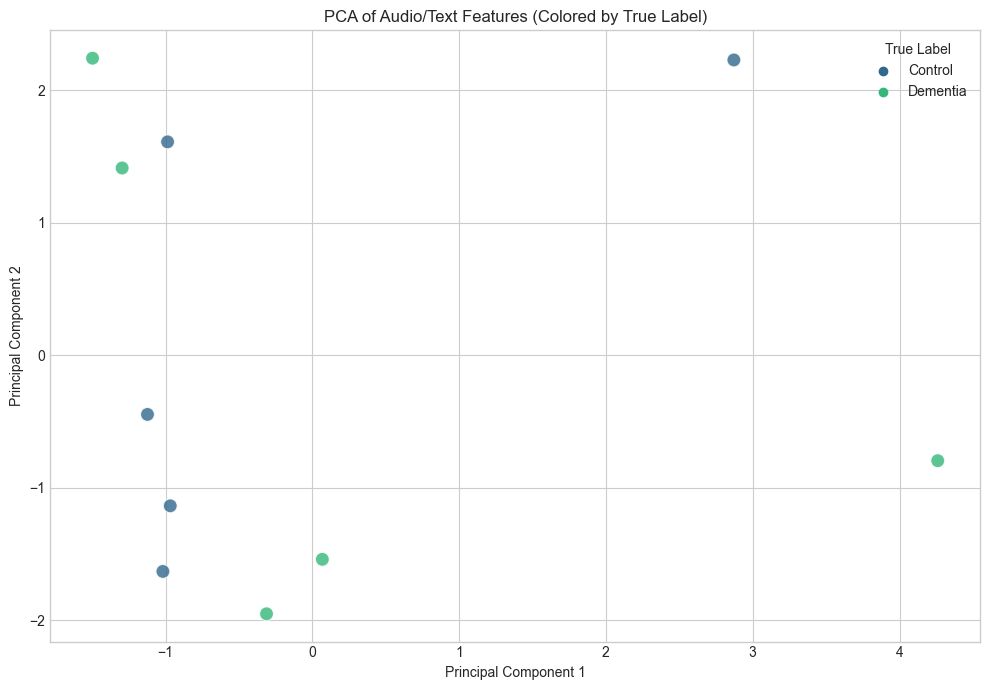

C:\Users\prach\AppData\Local\Temp\ipykernel_31048\2980571964.py:143: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


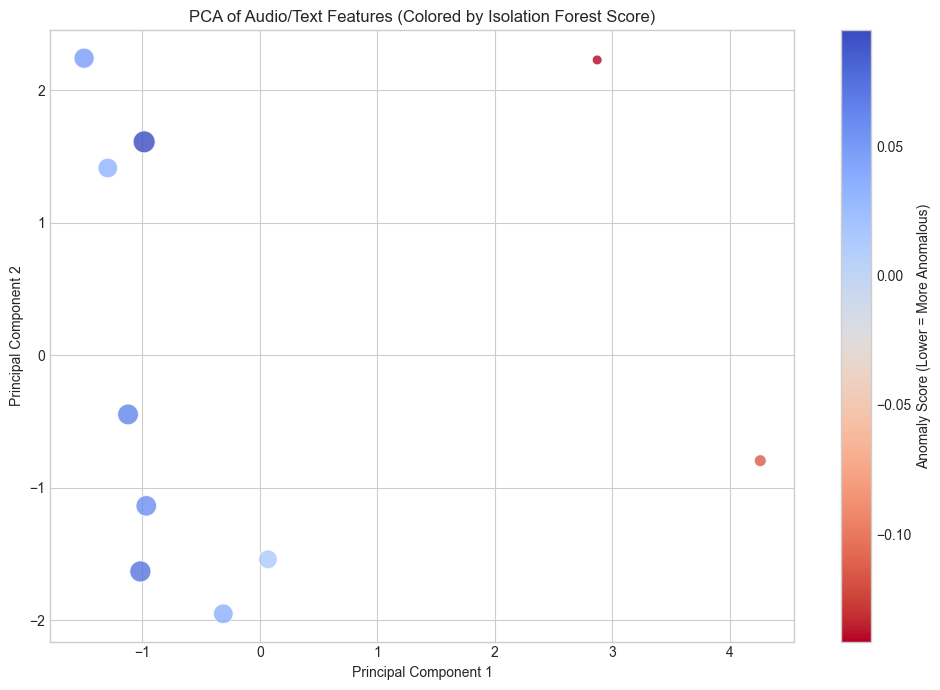

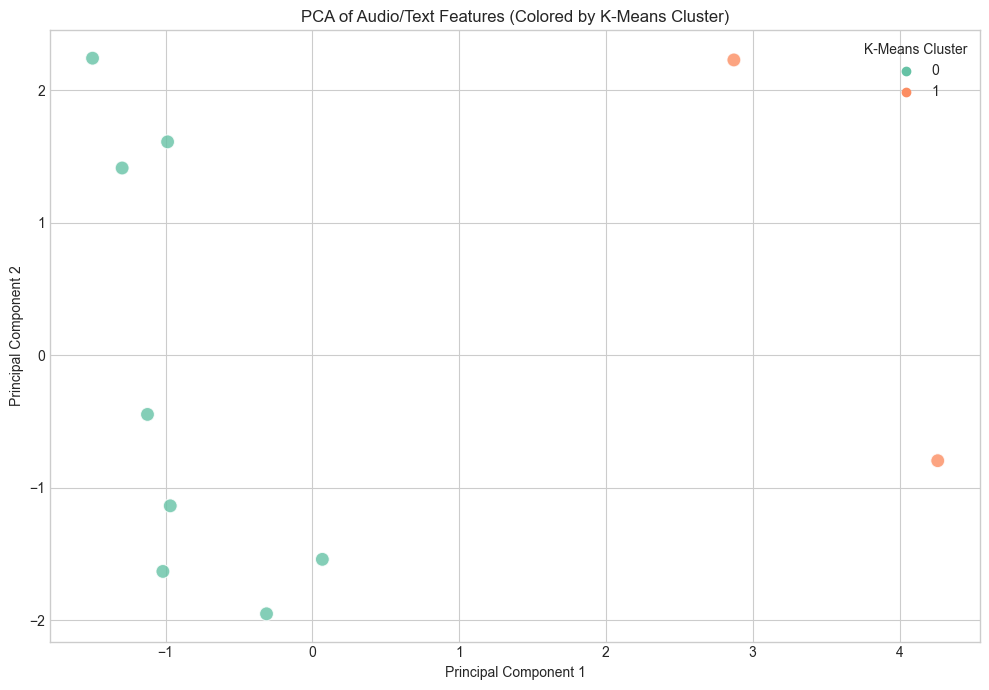


Comparing mean feature values between Control and Dementia groups...


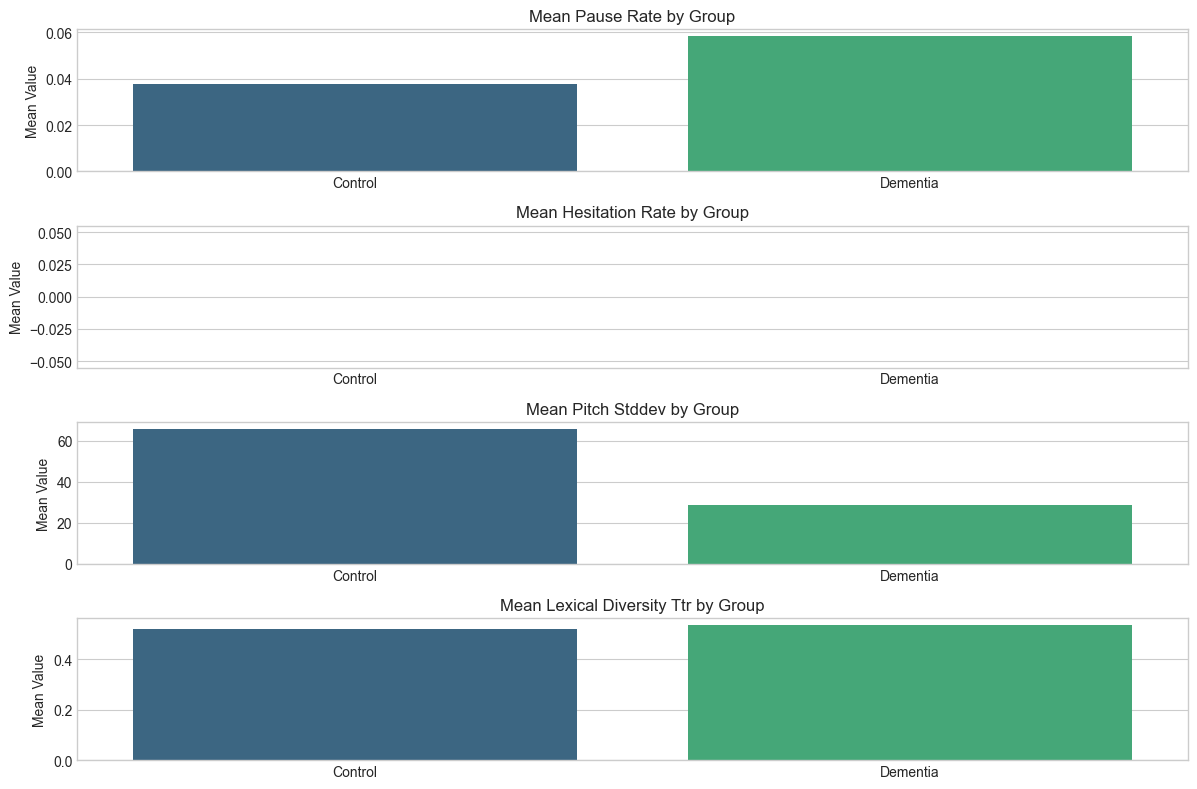


--- Unsupervised Analysis and Visualization Complete ---

Final DataFrame with Analysis Results:
         filename     label  anomaly_score  anomaly_prediction  \
0   control_0.wav   Control       0.058417                   1   
1   control_1.wav   Control      -0.141628                  -1   
2   control_2.wav   Control       0.063653                   1   
3   control_3.wav   Control       0.072956                   1   
4   control_4.wav   Control       0.095021                   1   
5  dementia_0.wav  Dementia      -0.113947                  -1   
6  dementia_1.wav  Dementia       0.048717                   1   
7  dementia_2.wav  Dementia       0.033696                   1   
8  dementia_3.wav  Dementia       0.036679                   1   
9  dementia_4.wav  Dementia       0.015215                   1   

   kmeans_cluster      pca1      pca2  speech_fraction  pause_rate  \
0               0 -0.967997 -1.136025         1.000000    0.000000   
1               1  2.871635  2.2301

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # To handle potential NaNs
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os # To use DATA_DIR again if needed

# --- Configuration ---
# Assume results_df is already loaded from the previous step
# If not, load it from the CSV:
DATA_DIR = r"C:\Users\prach\Desktop\MemoTag\data"
csv_path = os.path.join(DATA_DIR, "features_and_transcripts.csv")
try:
    results_df = pd.read_csv(csv_path)
    print("Loaded features from CSV.")
except FileNotFoundError:
    print(f"Error: CSV file not found at {csv_path}")
    print("Please ensure the previous script ran successfully and saved the CSV.")
    exit()

# Make sure results_df is defined (it should be from the previous code cell)
if 'results_df' not in locals():
    print("Error: 'results_df' DataFrame not found. Please run the previous feature extraction cell.")
    exit()

print("\n--- Starting Unsupervised Analysis ---")

# --- 1. Data Preparation ---

# Select only numerical feature columns
# Identify columns that are likely features (exclude object/string types like filename, label, transcript)
feature_columns = results_df.select_dtypes(include=np.number).columns.tolist()
# Remove duration if you don't want it as a direct feature for clustering/anomaly detection
if 'duration_s' in feature_columns:
    feature_columns.remove('duration_s')

print(f"Using features: {feature_columns}")
features_df = results_df[feature_columns].copy()

# Handle Missing Values (NaNs) using Median Imputation
# Check for NaNs before imputing
print(f"\nNaN count before imputation:\n{features_df.isnull().sum().to_string()}") # Use to_string for better multi-line display

# Always create and fit the imputer.
imputer = SimpleImputer(strategy='median')
# Fit the imputer and transform the data. Result is a NumPy array.
features_imputed_array = imputer.fit_transform(features_df) # Use fit_transform here

# Check if imputation actually happened (optional info)
if features_df.isnull().values.any():
    print(f"\nNaNs were imputed.")
else:
    print("\nNo NaNs found in feature columns; imputer is fitted and data passed through.")


# Feature Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed_array)
features_scaled_df = pd.DataFrame(features_scaled, columns=feature_columns, index=features_df.index)

print("\nFeatures prepared and scaled.")

# --- 2. Apply Isolation Forest ---
print("\nApplying Isolation Forest...")
# contamination='auto' is often okay, but since we expect ~50% dementia, let's try a higher value or 'auto'
# Lower contamination means fewer points are flagged as outliers. Let's try auto first.
iso_forest = IsolationForest(contamination='auto', random_state=42) # Or try contamination=0.3, 0.4, 0.5
iso_forest.fit(features_scaled_df)

# Get anomaly scores (lower = more anomalous) and predictions (-1 = anomaly, 1 = inlier)
anomaly_scores = iso_forest.decision_function(features_scaled_df)
anomaly_predictions = iso_forest.predict(features_scaled_df)

# Add results back to the main DataFrame
results_df['anomaly_score'] = anomaly_scores
results_df['anomaly_prediction'] = anomaly_predictions # -1 for anomalies (potential dementia), 1 for inliers (potential control)

print("Isolation Forest analysis complete.")
print(results_df[['filename', 'label', 'anomaly_score', 'anomaly_prediction']])


# --- 3. Apply K-Means Clustering (K=2) ---
print("\nApplying K-Means Clustering (K=2)...")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10) # n_init suppresses a warning
kmeans.fit(features_scaled_df)
cluster_labels = kmeans.labels_ # 0 or 1

# Add results back to the main DataFrame
results_df['kmeans_cluster'] = cluster_labels

print("K-Means clustering complete.")
print(results_df[['filename', 'label', 'kmeans_cluster']])

# Optional: Check alignment - does cluster 0 map more to Control or Dementia?
# crosstab = pd.crosstab(results_df['label'], results_df['kmeans_cluster'])
# print("\nK-Means Cluster vs True Label:\n", crosstab)


# --- 4. Apply PCA for Visualization ---
print("\nApplying PCA (2 components) for visualization...")
pca = PCA(n_components=2)
pca_results = pca.fit_transform(features_scaled_df)

# Add PCA results back to the main DataFrame
results_df['pca1'] = pca_results[:, 0]
results_df['pca2'] = pca_results[:, 1]

print("PCA complete.")


# --- 5. Analyze & Visualize ---
print("\nGenerating Visualizations...")

plt.style.use('seaborn-v0_8-whitegrid') # Use a clean style

# Plot 1: PCA Scatter Plot colored by True Label
plt.figure(figsize=(10, 7))
sns.scatterplot(data=results_df, x='pca1', y='pca2', hue='label', palette='viridis', s=100, alpha=0.8)
plt.title('PCA of Audio/Text Features (Colored by True Label)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='True Label')
plt.tight_layout()
plt.show()

# Plot 2: PCA Scatter Plot colored by Isolation Forest Score
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(data=results_df, x='pca1', y='pca2', hue='anomaly_score', size='anomaly_score',
                          palette='coolwarm_r', sizes=(50, 250), alpha=0.8) # _r reverses colormap (cool=low score=blue=anomaly)
plt.title('PCA of Audio/Text Features (Colored by Isolation Forest Score)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
norm = plt.Normalize(results_df['anomaly_score'].min(), results_df['anomaly_score'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=norm)
sm.set_array([])
# Remove the legend for size
scatter.legend_.remove()
# Add the colorbar
cbar = plt.colorbar(sm)
cbar.set_label('Anomaly Score (Lower = More Anomalous)')
plt.tight_layout()
plt.show()

# Plot 3: PCA Scatter Plot colored by K-Means Cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(data=results_df, x='pca1', y='pca2', hue='kmeans_cluster', palette='Set2', s=100, alpha=0.8)
plt.title('PCA of Audio/Text Features (Colored by K-Means Cluster)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='K-Means Cluster')
plt.tight_layout()
plt.show()


# Plot 4: Feature Comparison (Example: Pause Rate and Hesitation Rate)
# Select a few key features hypothesized to differ
features_to_compare = ['pause_rate', 'hesitation_rate', 'pitch_stddev', 'lexical_diversity_ttr']

# Ensure these columns exist after imputation/selection
features_to_compare = [f for f in features_to_compare if f in results_df.columns]

if features_to_compare:
    print(f"\nComparing mean feature values between Control and Dementia groups...")
    plt.figure(figsize=(12, len(features_to_compare) * 2))
    for i, feature in enumerate(features_to_compare):
        plt.subplot(len(features_to_compare), 1, i + 1)
        sns.barplot(data=results_df, x='label', y=feature, palette='viridis', estimator=np.mean, errorbar=None) # Use np.mean or other estimator
        plt.title(f'Mean {feature.replace("_", " ").title()} by Group')
        plt.xlabel('') # Remove x-label for subplots
        plt.ylabel('Mean Value')
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping feature comparison plot as specified features were not found.")


print("\n--- Unsupervised Analysis and Visualization Complete ---")

# Display the final DataFrame with scores and clusters
print("\nFinal DataFrame with Analysis Results:")
print(results_df[['filename', 'label', 'anomaly_score', 'anomaly_prediction', 'kmeans_cluster', 'pca1', 'pca2'] + feature_columns])

In [45]:
# --- Make sure necessary libraries are imported ---
import pandas as pd
import numpy as np
import librosa
import whisper # Ensure whisper is imported
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import os
import traceback # For detailed error prints if needed

# --- Ensure feature extraction functions are defined previously ---
# def extract_audio_features(y, sr): ...
# def extract_text_features(transcript, audio_duration_seconds): ...


def predict_risk_and_cluster(audio_path, whisper_model, feature_columns, imputer, scaler, iso_forest, kmeans, target_sr=16000):
    """
    Processes a single audio file, extracts features, and predicts anomaly score/label
    and cluster membership using pre-trained models.

    Args:
        audio_path (str): Path to the new audio file.
        whisper_model: The loaded Whisper model instance.
        feature_columns (list): List of feature names in the order used for training.
        imputer: The fitted SimpleImputer instance.
        scaler: The fitted StandardScaler instance.
        iso_forest: The fitted IsolationForest instance.
        kmeans: The fitted KMeans instance.
        target_sr (int): The target sampling rate.

    Returns:
        dict: A dictionary containing the transcript, predicted scores/labels,
              or an error message.
              Keys: 'transcript', 'extracted_features', 'anomaly_score',
                    'anomaly_prediction', 'kmeans_cluster', 'error' (None if successful).
    """
    print(f"\n--- Predicting for new file: {os.path.basename(audio_path)} ---")
    results = {
        "transcript": None,
        "extracted_features": None,
        "anomaly_score": np.nan,
        "anomaly_prediction": None,
        "kmeans_cluster": None,
        "error": None
    }

    try:
        # 1. Load Audio
        print("   Loading audio...")
        y, sr = librosa.load(audio_path, sr=target_sr, mono=True)
        audio_duration = librosa.get_duration(y=y, sr=sr)
        if audio_duration < 0.5:
            results["error"] = "Audio too short (< 0.5 seconds)"
            print(f"   Error: {results['error']}")
            return results
        print(f"   Audio loaded. Duration: {audio_duration:.2f} seconds.")

        # 2. Speech-to-Text (Whisper)
        print("   Transcribing with Whisper...")
        if y.dtype != np.float32:
            y = y.astype(np.float32)
        # Using language='en' as specified before, adjust if needed
        transcription_result = whisper_model.transcribe(y, language='en', fp16=False)
        transcript = transcription_result['text'].strip()
        results["transcript"] = transcript
        print(f"   Transcript: \"{transcript[:100]}...\"")

        # 3. Feature Extraction
        audio_features = extract_audio_features(y, sr)
        text_features = extract_text_features(transcript, audio_duration)
        all_features = {**audio_features, **text_features}
        results["extracted_features"] = all_features # Store extracted features

        # 4. Combine and Prepare Features in correct order
        # Create a DataFrame with one row, selecting only the required columns
        try:
             # Ensure all expected columns are present in extracted features before ordering
             feature_data = {col: all_features.get(col, np.nan) for col in feature_columns}
             new_features_df = pd.DataFrame([feature_data], columns=feature_columns)
        except Exception as e:
             results["error"] = f"Error preparing feature vector: {e}"
             print(f"   Error: {results['error']}")
             return results

        # Check for NaNs *after* extraction for the new file
        if new_features_df.isnull().values.any():
             print(f"   WARNING: NaNs detected in extracted features for new file:\n{new_features_df.isnull().sum().to_string()}")
             # Imputation will handle these
        else:
             print("   No NaNs detected in extracted features.")

        # 5. Impute Missing Values (using the *fitted* imputer)
        print("   Applying imputer...")
        # Imputer expects NumPy array
        features_imputed_array = imputer.transform(new_features_df.values) # Use transform()

        # 6. Scale Features (using the *fitted* scaler)
        print("   Applying scaler...")
        # Scaler expects NumPy array
        features_scaled_array = scaler.transform(features_imputed_array) # Use transform()

        # 7. Predict using fitted models
        print("   Making predictions...")
        results["anomaly_score"] = iso_forest.decision_function(features_scaled_array)[0]
        results["anomaly_prediction"] = int(iso_forest.predict(features_scaled_array)[0])
        results["kmeans_cluster"] = int(kmeans.predict(features_scaled_array)[0])

        print("   Prediction complete.")

    except Exception as e:
        results["error"] = f"An error occurred during processing: {e}"
        print(f"   Error: {results['error']}")
        # print(traceback.format_exc()) # Uncomment for detailed traceback

    return results



In [43]:
# --- Example Usage for a New File ---

# --- Ensure these objects exist from the analysis script ---
# whisper_model, feature_columns, imputer, scaler, iso_forest, kmeans, TARGET_SR
# Also ensure extract_audio_features and extract_text_features are defined

new_audio_file_path = r"C:\Users\prach\Desktop\nodementia\Angela Lansbury\Angela Lansbury_1.wav" # Replace with your actual file path

# --- Check if all necessary objects exist before calling ---
required_vars = ['whisper_model', 'feature_columns', 'imputer', 'scaler', 'iso_forest', 'kmeans', 'TARGET_SR']
missing_vars = [var for var in required_vars if var not in locals()]

if missing_vars:
    print(f"Error: Cannot run prediction. Missing required variables from analysis script: {missing_vars}")
elif not os.path.exists(new_audio_file_path):
    print(f"Error: New audio file not found at {new_audio_file_path}")
else:
    # Call the prediction function
    prediction_results = predict_risk_and_cluster(
        audio_path=new_audio_file_path,
        whisper_model=whisper_model,
        feature_columns=feature_columns,
        imputer=imputer,  # This should now exist after fixing the analysis script
        scaler=scaler,
        iso_forest=iso_forest,
        kmeans=kmeans,
        target_sr=TARGET_SR
    )

    # Print the results
    print("\n--- Prediction Results for New File ---")
    if prediction_results["error"]:
        print(f"Error: {prediction_results['error']}")
    else:
        print(f"Transcript: {prediction_results['transcript']}")
        # Optionally print extracted features
        # print("Extracted Features:")
        # for key, value in prediction_results["extracted_features"].items():
        #    if isinstance(value, float): print(f"  {key}: {value:.3f}")
        #    else: print(f"  {key}: {value}")
        print("-" * 20)
        print(f"Anomaly Score: {prediction_results['anomaly_score']:.4f} (Lower is more anomalous)")
        print(f"Anomaly Prediction: {prediction_results['anomaly_prediction']} (-1=Anomaly, 1=Inlier)")
        print(f"Predicted K-Means Cluster: {prediction_results['kmeans_cluster']}")
        # Add interpretation based on your K-Means cluster findings from the analysis script
        # Example: Check which cluster (0 or 1) contained mostly Dementia samples in your training run
        # Let's assume Cluster 0 was the mixed/dementia group in your previous run:
        if prediction_results['kmeans_cluster'] == 0:
             print("   -> Belongs to cluster associated with Dementia samples in training data.")
        else: # Assuming cluster 1 was the 'control-only' group
             print("   -> Belongs to cluster associated with distinct Control samples in training data.")

Error: Cannot run prediction. Missing required variables from analysis script: ['whisper_model', 'feature_columns', 'imputer', 'scaler', 'iso_forest', 'kmeans', 'TARGET_SR']


Loading Whisper model...
Whisper model loaded successfully.

Found 10 audio files to process for feature extraction.

Processing file 1/10: control_0.wav (Label: Control)
   Loading audio...
   Audio loaded. Duration: 63.00 seconds.
   Transcribing with Whisper...
   Transcript: "not worried because every I mean the picture opening Paris and it's a big hit in Paris. I mean and w..."
   Extracting audio features...
      Audio features extracted: {'speech_fraction': '1.000', 'pause_rate': '0.000', 'avg_pause_duration': 0, 'pitch_mean': '144.381', 'pitch_stddev': '47.744'}
   Extracting text features...
      Text features extracted: {'word_count': 144, 'speech_rate_wps': '2.286', 'hesitation_rate': '0.000', 'lexical_diversity_ttr': '0.521', 'avg_sentence_length': '20.571'}
   Features extracted and stored.

Processing file 2/10: control_1.wav (Label: Control)
   Loading audio...
   Audio loaded. Duration: 69.00 seconds.
   Transcribing with Whisper...
   Transcript: "It's like the Ford 

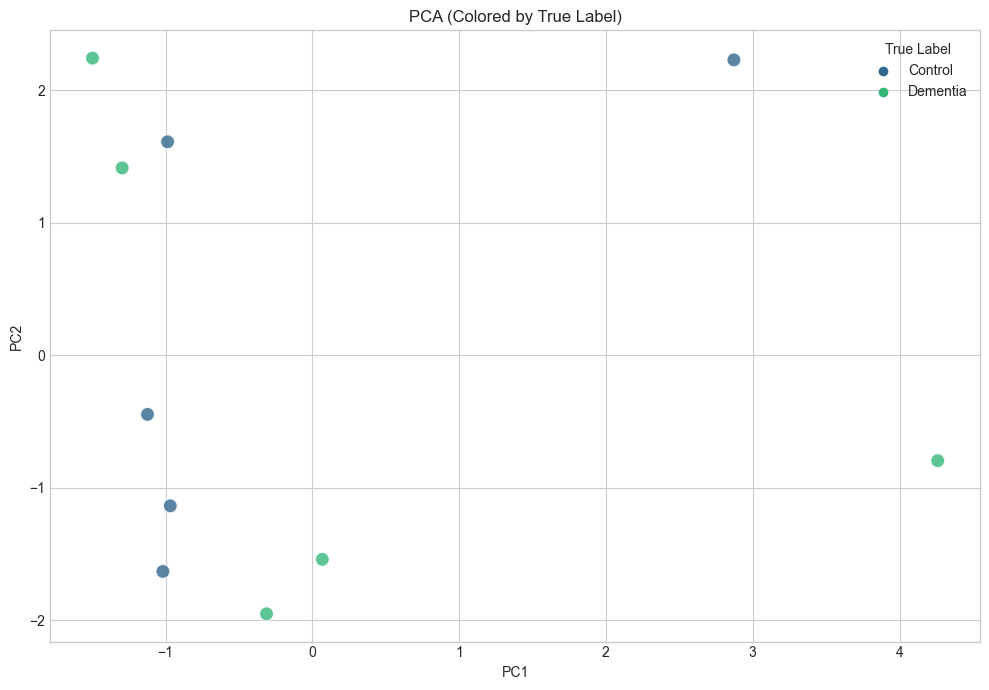

C:\Users\prach\AppData\Local\Temp\ipykernel_31048\974407524.py:353: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.title('PCA (Colored by Isolation Forest Score)'); plt.xlabel('PC1'); plt.ylabel('PC2'); norm = plt.Normalize(results_df['anomaly_score'].min(), results_df['anomaly_score'].max()); sm = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=norm); sm.set_array([]); scatter.legend_.remove(); cbar = plt.colorbar(sm); cbar.set_label('Anomaly Score (Lower = More Anomalous)'); plt.tight_layout(); plt.show()


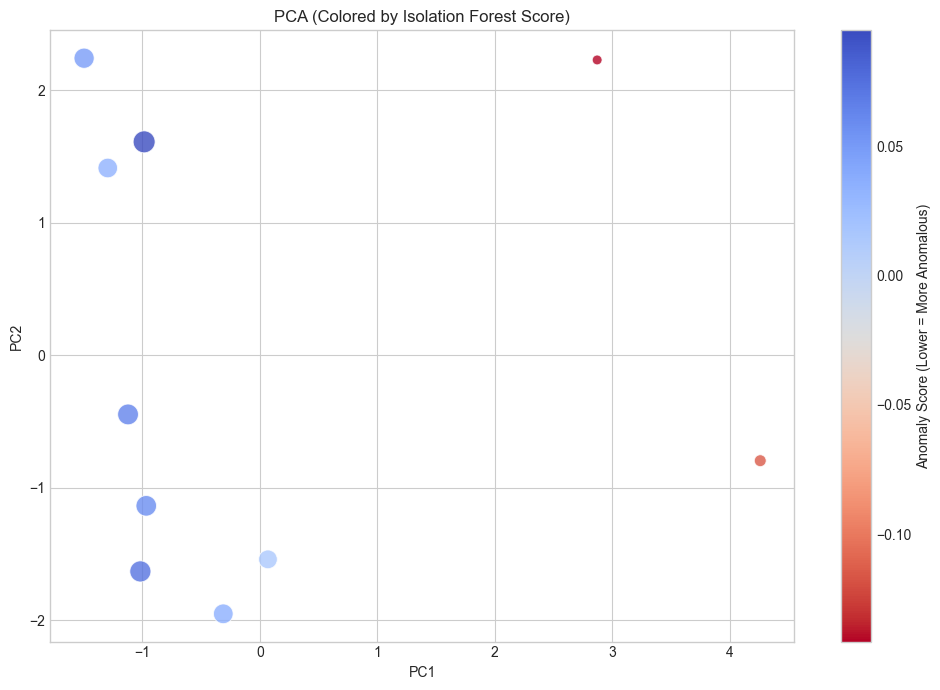

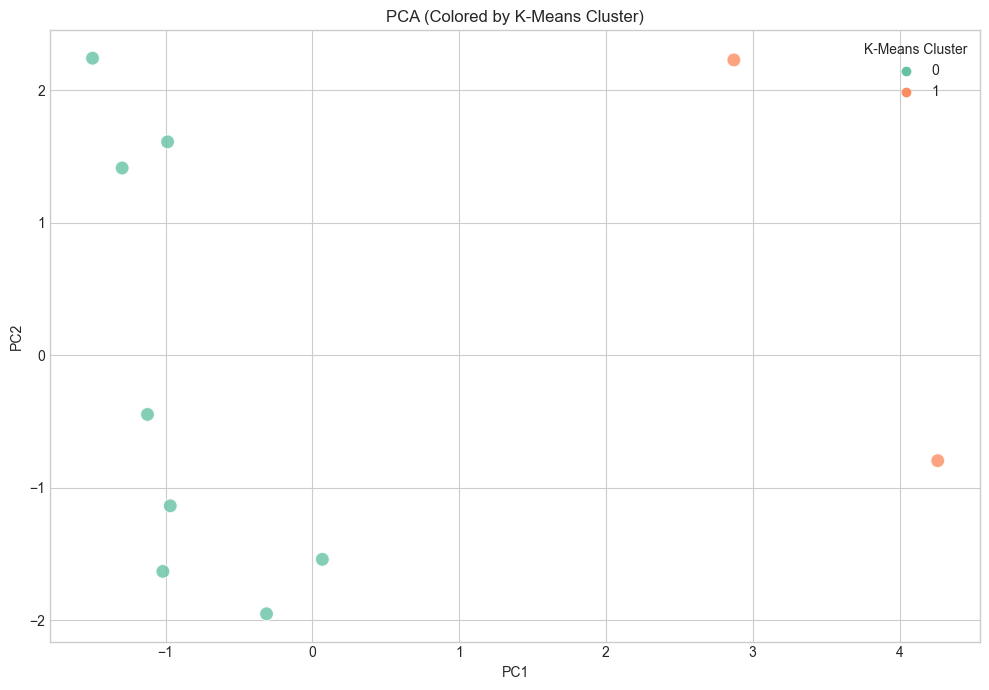


Comparing mean feature values between Control and Dementia groups...


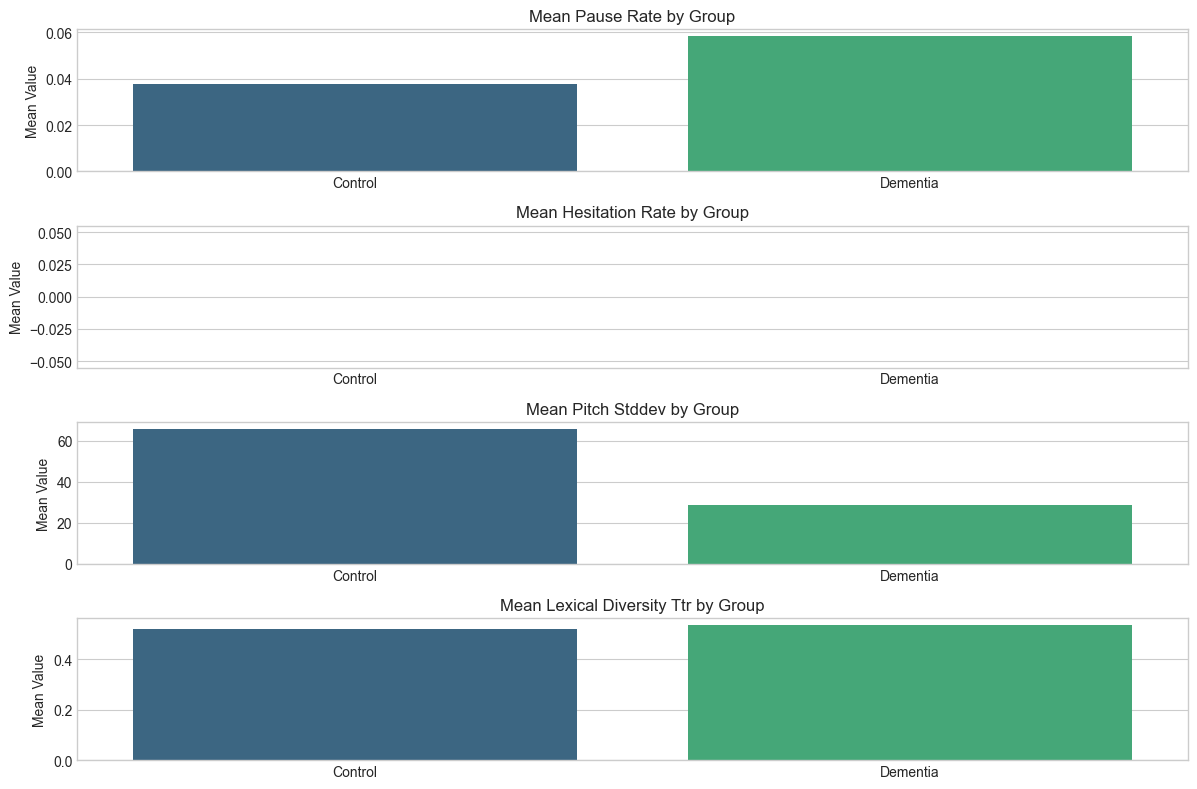


--- Unsupervised Analysis and Visualization Complete ---


In [50]:
# ============================================================
# Part 1: Imports and Setup
# ============================================================
import os
import glob
import librosa
import librosa.effects # Explicitly import effects
import whisper # Use the correct import name
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import collections # For Counter
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # To handle potential NaNs
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # For detailed error prints if needed

# --- Ensure NLTK data is available ---
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    print("Downloading NLTK 'punkt' tokenizer...")
    nltk.download('punkt')
    print("NLTK 'punkt' downloaded.")

# --- Configuration ---
# Base directory where Control/Dementia folders are located
DATA_DIR = r"C:\Users\prach\Desktop\MemoTag\data"
CONTROL_FOLDER = os.path.join(DATA_DIR, "Control")
DEMENTIA_FOLDER = os.path.join(DATA_DIR, "Dementia")
TARGET_SR = 16000 # Define TARGET_SR (Hz) for audio processing
OUTPUT_CSV_FILENAME = "features_and_transcripts.csv" # Output CSV file name

# --- Constants for Feature Extraction ---
PAUSE_THRESHOLD_DB = 40 # dB below peak to consider silence
MIN_SILENCE_DURATION_S = 0.25 # Minimum duration (seconds) for a pause
FMIN = librosa.note_to_hz('C2') # Min pitch frequency
FMAX = librosa.note_to_hz('C7') # Max pitch frequency
HESITATION_MARKERS = ["uh", "um", "ah", "eh", "er"] # List of hesitation words

# ============================================================
# Part 2: Load Whisper Model
# ============================================================
print("Loading Whisper model...")
try:
    # Using 'base' model. Consider 'base.en' if all audio is English.
    whisper_model = whisper.load_model("base")
    print("Whisper model loaded successfully.")
except Exception as e:
    print(f"FATAL ERROR: Error loading Whisper model: {e}")
    print("Please ensure 'openai-whisper' is installed and 'ffmpeg' is available.")
    exit()

# ============================================================
# Part 3: Define Feature Extraction Functions
# ============================================================

def extract_audio_features(y, sr):
    """
    Extracts acoustic features from the audio waveform.
    Returns a dictionary of features.
    """
    print(f"   Extracting audio features...")
    features = {}
    total_duration = librosa.get_duration(y=y, sr=sr)
    if total_duration == 0: total_duration = 1e-6 # Avoid division by zero for empty audio

    # 1. Pause and Speech Fraction Analysis
    try:
        hop_length_pauses = 512
        non_silent_intervals = librosa.effects.split(y, top_db=PAUSE_THRESHOLD_DB, hop_length=hop_length_pauses)
        speech_duration = sum(librosa.samples_to_time(interval[1] - interval[0], sr=sr)
                              for interval in non_silent_intervals)
        features['speech_fraction'] = speech_duration / total_duration
        pauses = []
        last_end_time = 0
        for start, end in non_silent_intervals:
            start_time = librosa.samples_to_time(start, sr=sr)
            end_time = librosa.samples_to_time(end, sr=sr)
            silence_duration = start_time - last_end_time
            if silence_duration >= MIN_SILENCE_DURATION_S:
                pauses.append(silence_duration)
            last_end_time = end_time
        final_silence = total_duration - last_end_time
        if final_silence >= MIN_SILENCE_DURATION_S:
             pauses.append(final_silence)
        num_pauses = len(pauses)
        features['pause_rate'] = num_pauses / total_duration
        features['avg_pause_duration'] = np.mean(pauses) if num_pauses > 0 else 0
    except Exception as e:
        print(f"      Warning: Error in pause analysis: {e}")
        features['speech_fraction'] = np.nan; features['pause_rate'] = np.nan; features['avg_pause_duration'] = np.nan

    # 2. Pitch Analysis (F0 Mean and Std Dev)
    try:
        frame_length_pitch = 2048; hop_length_pitch = 512
        f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=FMIN, fmax=FMAX, sr=sr, frame_length=frame_length_pitch, hop_length=hop_length_pitch)
        voiced_f0 = f0[voiced_flag]
        if voiced_f0 is not None and len(voiced_f0) > 1:
            voiced_f0 = voiced_f0[~np.isnan(voiced_f0)] # Remove NaNs from pitch results
            if len(voiced_f0) > 1:
                features['pitch_mean'] = np.mean(voiced_f0)
                features['pitch_stddev'] = np.std(voiced_f0) # This is pitch variability
            else: features['pitch_mean'] = np.nan; features['pitch_stddev'] = np.nan
        else: features['pitch_mean'] = np.nan; features['pitch_stddev'] = np.nan
    except Exception as e:
        print(f"      Warning: Error in pitch analysis: {e}")
        features['pitch_mean'] = np.nan; features['pitch_stddev'] = np.nan

    print(f"      Audio features extracted: { {k: f'{v:.3f}' if isinstance(v, (float, np.number)) and not np.isnan(v) else v for k, v in features.items()} }")
    return features

def extract_text_features(transcript, audio_duration_seconds):
    """
    Extracts linguistic features from the transcript.
    Returns a dictionary of features.
    """
    print(f"   Extracting text features...")
    features = {}
    # Ensure duration is not zero to avoid division errors
    if audio_duration_seconds <= 0: audio_duration_seconds = 1e-6

    # Handle empty or whitespace-only transcripts gracefully
    if not transcript or not transcript.strip():
        print("      Transcript is empty or whitespace only, returning default/NaN text features.")
        features['word_count'] = 0; features['speech_rate_wps'] = 0; features['hesitation_rate'] = 0
        features['lexical_diversity_ttr'] = np.nan; features['avg_sentence_length'] = 0
        return features

    try:
        # 1. Basic Word Count and Speech Rate
        words = word_tokenize(transcript.lower())
        cleaned_words = [word for word in words if word.isalnum() or '-' in word]
        words_for_hesitation = [word for word in words if word.isalnum()] # Use for hesitation rate

        features['word_count'] = len(cleaned_words)
        features['speech_rate_wps'] = features['word_count'] / audio_duration_seconds

        # 2. Hesitation Rate
        hesitation_count = sum(1 for word in words_for_hesitation if word in HESITATION_MARKERS)
        total_words_for_hes_rate = len(words_for_hesitation)
        features['hesitation_rate'] = hesitation_count / total_words_for_hes_rate if total_words_for_hes_rate > 0 else 0

        # 3. Lexical Diversity (TTR) - Use cleaned words
        if features['word_count'] > 0:
            unique_words = set(cleaned_words); features['lexical_diversity_ttr'] = len(unique_words) / features['word_count']
        else: features['lexical_diversity_ttr'] = np.nan

        # 4. Average Sentence Length
        sentences = sent_tokenize(transcript)
        if sentences:
            sentence_lengths = []
            for sent in sentences:
                 sent_words = word_tokenize(sent.lower()); sent_cleaned_words = [word for word in sent_words if word.isalnum() or '-' in word]
                 if sent_cleaned_words: sentence_lengths.append(len(sent_cleaned_words))
            features['avg_sentence_length'] = np.mean(sentence_lengths) if sentence_lengths else 0
        else: features['avg_sentence_length'] = 0
    except Exception as e:
        print(f"      Warning: Error in text feature extraction: {e}")
        features.setdefault('word_count', 0); features.setdefault('speech_rate_wps', 0); features.setdefault('hesitation_rate', 0)
        features.setdefault('lexical_diversity_ttr', np.nan); features.setdefault('avg_sentence_length', 0)

    print(f"      Text features extracted: { {k: f'{v:.3f}' if isinstance(v, (float, np.number)) and not np.isnan(v) else v for k, v in features.items()} }")
    return features

# ============================================================
# Part 4: Feature Extraction Loop (Process 10 files)
# ============================================================
# This part assumes the 10 WAV files exist in the Control/Dementia folders
results = []
audio_files = []
control_files = glob.glob(os.path.join(CONTROL_FOLDER, "*.wav"))
dementia_files = glob.glob(os.path.join(DEMENTIA_FOLDER, "*.wav"))
for f in control_files: audio_files.append({"path": f, "label": "Control"})
for f in dementia_files: audio_files.append({"path": f, "label": "Dementia"})

if not audio_files:
     print(f"FATAL ERROR: No .wav files found in {CONTROL_FOLDER} or {DEMENTIA_FOLDER}.")
     print(f"Please ensure the data preparation script ran and saved files to the correct DATA_DIR: {DATA_DIR}")
     exit()

print(f"\nFound {len(audio_files)} audio files to process for feature extraction.")

# Process each file
for i, file_info in enumerate(audio_files):
    file_path = file_info["path"]; true_label = file_info["label"]
    print(f"\nProcessing file {i+1}/{len(audio_files)}: {os.path.basename(file_path)} (Label: {true_label})")
    # Define default feature dicts in case of error
    audio_features = {k: np.nan for k in ['speech_fraction', 'pause_rate', 'avg_pause_duration', 'pitch_mean', 'pitch_stddev']}
    text_features = {k: np.nan for k in ['word_count', 'speech_rate_wps', 'hesitation_rate', 'lexical_diversity_ttr', 'avg_sentence_length']}
    transcript = ""
    audio_duration = 0
    error_msg = None
    try:
        print(f"   Loading audio..."); y, sr = librosa.load(file_path, sr=TARGET_SR, mono=True); audio_duration = librosa.get_duration(y=y, sr=sr)
        print(f"   Audio loaded. Duration: {audio_duration:.2f} seconds.")
        if audio_duration < 0.5:
             print("      Audio too short, skipping transcription and feature extraction.")
        else:
             print(f"   Transcribing with Whisper...");
             if y.dtype != np.float32: y = y.astype(np.float32)
             transcription_result = whisper_model.transcribe(y, language='en', fp16=False); transcript = transcription_result['text'].strip()
             print(f"   Transcript: \"{transcript[:100]}...\"")
             # Extract features only if transcription was successful
             audio_features = extract_audio_features(y, sr)
             text_features = extract_text_features(transcript, audio_duration)
        print(f"   Features extracted and stored.")
    except Exception as e:
        print(f"   !!! ERROR processing file {file_path}: {e}")
        error_msg = str(e) # Store error message

    # Store Results for this file
    file_results = {"filename": os.path.basename(file_path), "label": true_label, "duration_s": audio_duration, "transcript": transcript}
    file_results.update(audio_features); file_results.update(text_features)
    if error_msg: file_results["error"] = error_msg # Add error if occurred
    results.append(file_results)

# --- Convert results to DataFrame ---
results_df = pd.DataFrame(results)
print("\n\n--- Feature Extraction Summary ---")
# Display relevant columns, handle potential 'error' column
_expected_audio_cols = ['speech_fraction', 'pause_rate', 'avg_pause_duration', 'pitch_mean', 'pitch_stddev']
_expected_text_cols = ['word_count', 'speech_rate_wps', 'hesitation_rate', 'lexical_diversity_ttr', 'avg_sentence_length']
display_cols = ["filename", "label", "duration_s"] + _expected_audio_cols + _expected_text_cols
if 'error' in results_df.columns: display_cols.append('error')
# Ensure all expected columns exist before displaying
display_cols = [col for col in display_cols if col in results_df.columns]
print("\nFeature DataFrame Head:")
print(results_df[display_cols].head())

# --- Save features ---
output_csv_path = os.path.join(DATA_DIR, OUTPUT_CSV_FILENAME)
try:
    results_df.to_csv(output_csv_path, index=False, encoding='utf-8')
    print(f"\nFeatures saved to: {output_csv_path}")
except Exception as e:
    print(f"\nWarning: Error saving features to CSV: {e}")

# ============================================================
# Part 5: Unsupervised Analysis (Using results_df)
# ============================================================
print("\n--- Starting Unsupervised Analysis ---")

# --- Optional: Filter out bad samples like dementia_2.wav ---
# Uncomment the next lines to filter based on filename if needed
# filename_to_remove = 'dementia_2.wav'
# if filename_to_remove in results_df['filename'].values:
#      original_count = len(results_df)
#      results_df = results_df[results_df['filename'] != filename_to_remove].copy()
#      print(f"\nRemoved sample '{filename_to_remove}' for analysis. Original size: {original_count}, New size: {len(results_df)}")
# else:
#      print(f"\nSample '{filename_to_remove}' not found, proceeding with all {len(results_df)} samples.")

# --- 1. Data Preparation ---
# Define feature columns based on expected output of extraction functions
feature_columns = _expected_audio_cols + _expected_text_cols
print(f"Using features for analysis: {feature_columns}")

# Select only the valid feature columns that actually exist in the DataFrame
valid_feature_columns = [col for col in feature_columns if col in results_df.columns]
if not valid_feature_columns:
    print("FATAL ERROR: No valid numerical feature columns found in the DataFrame for analysis."); exit()
features_df = results_df[valid_feature_columns].copy()

# --- Imputation ---
print(f"\nNaN count before imputation:\n{features_df.isnull().sum().to_string()}")
imputer = SimpleImputer(strategy='median') # Define imputer
features_imputed_array = imputer.fit_transform(features_df) # Fit and transform
if features_df.isnull().values.any(): print(f"NaNs were imputed.")
else: print("No NaNs found in feature columns; imputer is fitted.")

# --- Scaling ---
scaler = StandardScaler() # Define scaler
features_scaled_array = scaler.fit_transform(features_imputed_array) # Fit and transform
features_scaled_df = pd.DataFrame(features_scaled_array, columns=valid_feature_columns, index=features_df.index)
print("\nFeatures prepared, imputed (if needed), and scaled.")

# --- 2. Apply Isolation Forest ---
print("\nApplying Isolation Forest...")
iso_forest = IsolationForest(contamination='auto', random_state=42) # Define iso_forest
iso_forest.fit(features_scaled_df) # Fit model
anomaly_scores = iso_forest.decision_function(features_scaled_df)
anomaly_predictions = iso_forest.predict(features_scaled_df)
# Add results back to the *original* results_df using the index
results_df['anomaly_score'] = pd.Series(anomaly_scores, index=features_scaled_df.index)
results_df['anomaly_prediction'] = pd.Series(anomaly_predictions, index=features_scaled_df.index)
print("Isolation Forest analysis complete.")

# --- 3. Apply K-Means Clustering ---
print("\nApplying K-Means Clustering (K=2)...")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10) # Define kmeans
kmeans.fit(features_scaled_df) # Fit model
cluster_labels = kmeans.labels_
# Add results back to the *original* results_df using the index
results_df['kmeans_cluster'] = pd.Series(cluster_labels, index=features_scaled_df.index)
print("K-Means clustering complete.")

print("\nDetermining Dementia-like Cluster ID from Training Data...")
# <<< MODIFICATION START: Initialize with a default value >>>
dementia_cluster_id = 0 # Default to cluster 0 if detection fails
control_cluster_id = 1
# <<< MODIFICATION END >>>

if 'kmeans_cluster' in results_df.columns and 'label' in results_df.columns:
    cluster_analysis_df = results_df[['label', 'kmeans_cluster']].dropna()
    if not cluster_analysis_df.empty and 'Dementia' in cluster_analysis_df['label'].unique():
        try:
            cluster_counts = cluster_analysis_df.groupby(['kmeans_cluster', 'label']).size().unstack(fill_value=0)
            print("\nCluster composition (Training Data):")
            print(cluster_counts)
            if 'Dementia' in cluster_counts.columns and not cluster_counts['Dementia'].empty:
                 # Assign cluster with max Dementia samples as dementia_cluster_id
                 dementia_cluster_id = cluster_counts['Dementia'].idxmax()
                 # Assign the *other* cluster as control_cluster_id (assumes K=2)
                 control_cluster_id = next(iter(set(cluster_counts.index) - {dementia_cluster_id}), 1 - dementia_cluster_id) # More robust way for K=2
                 print(f"Determined Dementia-like Cluster ID: {dementia_cluster_id}")
                 print(f"Determined Control-like Cluster ID: {control_cluster_id}")
            else:
                 print("Warning: 'Dementia' label found, but perhaps only in one cluster or counts failed.")
                 print(f"Using fallback Dementia-like Cluster ID: {dementia_cluster_id}") # Use default
        except Exception as e:
            print(f"Warning: Could not determine dementia cluster automatically: {e}")
            print(f"Using fallback Dementia-like Cluster ID: {dementia_cluster_id}") # Use default
    else:
         print("Warning: Cannot determine dementia cluster - missing labels, clusters, or Dementia samples.")
         print(f"Using fallback Dementia-like Cluster ID: {dementia_cluster_id}") # Use default
else:
    print("Warning: Cannot determine dementia cluster - necessary columns missing.")
    print(f"Using fallback Dementia-like Cluster ID: {dementia_cluster_id}")

# --- 4. Apply PCA ---
print("\nApplying PCA (2 components) for visualization...")
pca = PCA(n_components=2)
pca_results = pca.fit_transform(features_scaled_df) # Use scaled data
# Add results back to the *original* results_df using the index
results_df['pca1'] = pd.Series(pca_results[:, 0], index=features_scaled_df.index)
results_df['pca2'] = pd.Series(pca_results[:, 1], index=features_scaled_df.index)
print("PCA complete.")

# --- 5. Analyze & Visualize ---
print("\nGenerating Visualizations...")
plt.style.use('seaborn-v0_8-whitegrid')
# Plot 1: PCA by True Label
plt.figure(figsize=(10, 7)); sns.scatterplot(data=results_df, x='pca1', y='pca2', hue='label', palette='viridis', s=100, alpha=0.8)
plt.title('PCA (Colored by True Label)'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(title='True Label'); plt.tight_layout(); plt.show()
# Plot 2: PCA by Anomaly Score
plt.figure(figsize=(10, 7)); scatter = sns.scatterplot(data=results_df, x='pca1', y='pca2', hue='anomaly_score', size='anomaly_score', palette='coolwarm_r', sizes=(50, 250), alpha=0.8)
plt.title('PCA (Colored by Isolation Forest Score)'); plt.xlabel('PC1'); plt.ylabel('PC2'); norm = plt.Normalize(results_df['anomaly_score'].min(), results_df['anomaly_score'].max()); sm = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=norm); sm.set_array([]); scatter.legend_.remove(); cbar = plt.colorbar(sm); cbar.set_label('Anomaly Score (Lower = More Anomalous)'); plt.tight_layout(); plt.show()
# Plot 3: PCA by K-Means Cluster
plt.figure(figsize=(10, 7)); sns.scatterplot(data=results_df, x='pca1', y='pca2', hue='kmeans_cluster', palette='Set2', s=100, alpha=0.8)
plt.title('PCA (Colored by K-Means Cluster)'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(title='K-Means Cluster'); plt.tight_layout(); plt.show()
# Plot 4: Feature Comparison
features_to_compare = ['pause_rate', 'hesitation_rate', 'pitch_stddev', 'lexical_diversity_ttr']
# Ensure columns exist in the dataframe used for plotting
plot_features = [f for f in features_to_compare if f in results_df.columns]
if plot_features:
    print(f"\nComparing mean feature values between Control and Dementia groups...")
    plt.figure(figsize=(12, len(plot_features) * 2))
    for i, feature in enumerate(plot_features):
        # Check if feature has non-NaN values before plotting
        if results_df[feature].notna().any():
             plt.subplot(len(plot_features), 1, i + 1); sns.barplot(data=results_df, x='label', y=feature, palette='viridis', estimator=np.mean, errorbar=None)
             plt.title(f'Mean {feature.replace("_", " ").title()} by Group'); plt.xlabel(''); plt.ylabel('Mean Value')
        else:
             print(f"Skipping plot for {feature} as it contains only NaN values.")
    plt.tight_layout(); plt.show()
else: print("\nSkipping feature comparison plot as specified features were not found.")
print("\n--- Unsupervised Analysis and Visualization Complete ---")


def predict_risk_and_cluster(audio_path, whisper_model, feature_columns, imputer, scaler, iso_forest, kmeans, target_sr=16000):
    """
    Processes a single audio file, extracts features, and predicts anomaly score/label
    and cluster membership using pre-trained models.
    
    Args:
        audio_path (str): Path to the audio file
        whisper_model: Loaded whisper model
        feature_columns (list): List of feature column names to use
        imputer: Fitted SimpleImputer
        scaler: Fitted StandardScaler
        iso_forest: Fitted IsolationForest
        kmeans: Fitted KMeans
        target_sr (int): Target sample rate for audio
        
    Returns:
        dict: Prediction results including transcript, features, anomaly score, etc.
    """
    print(f"\n--- Predicting for new file: {os.path.basename(audio_path)} ---")
    
    # Check if file exists
    if not os.path.exists(audio_path):
        return {"error": f"Audio file not found at: {audio_path}", 
                "transcript": None, "extracted_features": None, 
                "anomaly_score": np.nan, "anomaly_prediction": None, "kmeans_cluster": None}
    
    results = {"transcript": None, "extracted_features": None, 
               "anomaly_score": np.nan, "anomaly_prediction": None, "kmeans_cluster": None, "error": None}
    
    try:
        print("   Loading audio...")
        y, sr = librosa.load(audio_path, sr=target_sr, mono=True)
        audio_duration = librosa.get_duration(y=y, sr=sr)
        
        if audio_duration < 0.5:
            results["error"] = "Audio too short (< 0.5 seconds)"
            print(f"   Error: {results['error']}")
            return results
            
        print(f"   Audio loaded. Duration: {audio_duration:.2f} seconds.")
        
        # Ensure audio is float32 for Whisper
        if y.dtype != np.float32:
            y = y.astype(np.float32)
            
        # Transcribe with Whisper
        print("   Transcribing with Whisper...")
        transcription_result = whisper_model.transcribe(y, language='en', fp16=False)
        transcript = transcription_result['text'].strip()
        results["transcript"] = transcript
        print(f"   Transcript: \"{transcript[:100]}...\"")
        
        # Extract features
        # These functions should be defined in the global scope
        audio_features = extract_audio_features(y, sr)
        text_features = extract_text_features(transcript, audio_duration)
        all_features = {**audio_features, **text_features}
        results["extracted_features"] = all_features
        
        # Create features dataframe with consistent columns
        feature_data = {}
        for col in feature_columns:
            feature_data[col] = all_features.get(col, np.nan)
        
        new_features_df = pd.DataFrame([feature_data], columns=feature_columns)
        
        # Check for NaNs
        if new_features_df.isnull().values.any():
            print(f"   WARNING: NaNs detected in extracted features, will be imputed:\n{new_features_df.isnull().sum().to_string()}")
        
        # Apply preprocessing pipeline
        features_imputed_array = imputer.transform(new_features_df)
        features_scaled_array = scaler.transform(features_imputed_array)
        
        # Get predictions
        results["anomaly_score"] = float(iso_forest.decision_function(features_scaled_array)[0])
        results["anomaly_prediction"] = int(iso_forest.predict(features_scaled_array)[0])
        results["kmeans_cluster"] = int(kmeans.predict(features_scaled_array)[0])
        
        print("   Prediction complete.")
        
    except Exception as e:
        import traceback
        results["error"] = f"An error occurred during prediction: {str(e)}"
        print(f"   Error: {results['error']}")
        print(traceback.format_exc())
        
    return results

In [52]:
# ============================================================
# (Assume Parts 1-5 ran successfully and defined necessary variables
# like DATA_DIR, valid_feature_columns, imputer, scaler, iso_forest, kmeans,
# whisper_model, TARGET_SR, results_df, and dementia_cluster_id)
# ============================================================

# ============================================================
# Part 6: Save Trained Models and Components for Future Use  <<< UPDATED
# ============================================================
print("\n--- Saving Trained Models and Components ---")

# Create a models directory if it doesn't exist
MODELS_DIR = os.path.join(DATA_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)
MODELS_FILENAME = 'models.pkl' # Define filename
models_path = os.path.join(MODELS_DIR, MODELS_FILENAME)

# Prepare the dictionary with all necessary components for prediction
# --- Includes the dementia_cluster_id determined in Part 5 ---
models_to_save = {
    'feature_columns': valid_feature_columns, # List of feature names used
    'imputer': imputer,                       # Fitted imputer
    'scaler': scaler,                         # Fitted scaler
    'isolation_forest': iso_forest,           # Fitted Isolation Forest model
    'kmeans': kmeans,                         # Fitted KMeans model
    'dementia_cluster_id': dementia_cluster_id # <<< ADDED: The cluster ID identified as Dementia-like
}

# Save the dictionary using pickle
try:
    with open(models_path, 'wb') as f:
        pickle.dump(models_to_save, f)
    print(f"Models and components saved successfully to: {models_path}")
except Exception as e:
    print(f"Error saving models: {e}")

# ============================================================
# Part 7: Prediction Function for New Audio Files             <<< UPDATED
# ============================================================
print("\n--- Setting Up Prediction Function ---")

# Note: predict_risk_and_cluster function should be defined earlier (as in the full script)
# Ensure predict_risk_and_cluster is defined before predict_new_file

def predict_new_file(new_audio_file_path, models_dict=None, models_path=None, whisper_model=None):
    """
    Run prediction on a new audio file using either provided models dictionary
    or loading saved models from disk. Calculates a simplified risk score.

    Args:
        new_audio_file_path (str): Path to the audio file to analyze.
        models_dict (dict, optional): Dictionary containing the trained models & components.
                                      If provided, models_path is ignored.
        models_path (str, optional): Path to saved models file (.pkl). Used if models_dict is None.
        whisper_model: Pre-loaded whisper model instance (loads 'base' if None).

    Returns:
        dict: Prediction results including risk score and category.
    """
    print(f"\nPredicting for file: {os.path.basename(new_audio_file_path)}")

    # Internal results dictionary
    prediction_output = {"error": None}

    try:
        # --- Load Models and Components ---
        if models_dict:
            print("Using models dictionary passed in arguments.")
            models = models_dict
        elif models_path and os.path.exists(models_path):
            print(f"Loading models from {models_path}...")
            with open(models_path, 'rb') as f:
                models = pickle.load(f)
            print("Models loaded successfully from file.")
        else:
            raise ValueError("No models dictionary provided and models_path is invalid or not found.")

        # --- Extract required components from loaded models ---
        try:
            feature_columns = models['feature_columns']
            imputer = models['imputer']
            scaler = models['scaler']
            iso_forest = models['isolation_forest']
            kmeans = models['kmeans']
            # <<< Load the dementia_cluster_id determined during training >>>
            dementia_cluster_id = models.get('dementia_cluster_id', 0) # Default to 0 if not saved
            print(f"Using Dementia-like Cluster ID: {dementia_cluster_id} (from saved model)")
        except KeyError as e:
            raise ValueError(f"Saved models file is missing required component: {e}")

        # --- Load Whisper model if not provided ---
        if whisper_model is None:
            print("Loading Whisper model (base)...")
            whisper_model = whisper.load_model("base")
            print("Whisper model loaded successfully.")

        # --- Call the core prediction function (assumed defined earlier) ---
        raw_results = predict_risk_and_cluster(
            audio_path=new_audio_file_path,
            whisper_model=whisper_model,
            feature_columns=feature_columns,
            imputer=imputer,
            scaler=scaler,
            iso_forest=iso_forest,
            kmeans=kmeans,
            target_sr=TARGET_SR # Assumes TARGET_SR is defined globally or passed
        )

        # --- Process and Interpret Results ---
        prediction_output.update(raw_results) # Copy results like transcript, scores, etc.

        print("\n--- Prediction Results ---")
        if prediction_output.get("error"):
            print(f"Error during feature extraction/prediction: {prediction_output['error']}")
        else:
            print(f"Transcript: \"{prediction_output.get('transcript', '')[:100]}...\"")
            print(f"Anomaly Score: {prediction_output.get('anomaly_score', np.nan):.4f} (Lower is more anomalous)")
            print(f"Anomaly Prediction: {prediction_output.get('anomaly_prediction')} (-1=Anomaly, 1=Normal)")
            print(f"Predicted K-Means Cluster: {prediction_output.get('kmeans_cluster')}")

            # --- Simplified Risk Assessment --- <<< UPDATED LOGIC
            print("\n--- Risk Assessment (Simplified) ---")

            # Component 1: Anomaly Risk (1 if anomaly, 0 if normal)
            anomaly_risk = 1 if prediction_output.get('anomaly_prediction') == -1 else 0
            print(f"Anomaly Component (1=Anomaly): {anomaly_risk}")

            # Component 2: Cluster Risk (1 if in dementia-like cluster, 0 otherwise)
            predicted_cluster = prediction_output.get('kmeans_cluster')
            cluster_risk = 1 if predicted_cluster == dementia_cluster_id else 0
            print(f"Cluster Component (1=In Dementia Cluster {dementia_cluster_id}): {cluster_risk}")

            # --- Combine into a simple risk score (0-100 scale) ---
            # Equal weighting: 50 points for being an anomaly, 50 points for being in dementia cluster
            risk_score = (anomaly_risk * 50) + (cluster_risk * 50)
            # No clamping needed as components are 0 or 1.

            print(f"Cognitive Decline Risk Score: {risk_score:.0f}/100")

            # Categorize the risk
            if risk_score >= 75: # High if both components trigger (or just anomaly if cluster is 0)
                risk_category = "High Risk"
            elif risk_score >= 50: # Moderate if one component triggers
                risk_category = "Moderate Risk"
            else: # Low/Minimal if no components trigger
                risk_category = "Low/Minimal Risk"

            print(f"Risk Category: {risk_category}")

            # Store risk metrics in results
            prediction_output['risk_score'] = risk_score
            prediction_output['risk_category'] = risk_category

    except Exception as e:
        error_msg = f"Error in prediction pipeline: {str(e)}"
        print(error_msg)
        # print(traceback.format_exc()) # Uncomment for full debug trace
        prediction_output["error"] = error_msg # Ensure error is stored

    return prediction_output

# ============================================================
# Part 8: Example Usage - Testing on an Existing File         <<< UPDATED
# ============================================================
print("\n--- Testing Prediction on an Existing File ---")

# Check if necessary variables exist (should if run sequentially)
if 'audio_files' not in locals(): audio_files = [] # Avoid error if feature extraction was skipped
if 'models_to_save' not in locals(): models_to_save = None # Use None if saving failed
if 'whisper_model' not in locals(): whisper_model = None # Ensure it's defined or None

if audio_files and models_to_save and whisper_model:
    # --- Test using models currently in memory ---
    example_file = r"C:\Users\prach\Desktop\nodementia\Angela Lansbury\Angela Lansbury_1.wav" # Get path of the first training file
    print(f"\nTesting prediction function (using models in memory) on: {os.path.basename(example_file)}")
    test_results_memory = predict_new_file(
        new_audio_file_path=example_file,
        models_dict=models_to_save, # Use the dictionary we just created
        whisper_model=whisper_model # Use the loaded model
    )

    # --- Test loading models from disk ---
    print(f"\nTesting prediction function (loading models from disk) on: {os.path.basename(example_file)}")
    test_results_disk = predict_new_file(
        new_audio_file_path=example_file,
        models_path=models_path, # Use the path where models were saved
        whisper_model=whisper_model # Pass whisper model to avoid reloading (optional)
        # If you omit whisper_model, it will reload it inside the function
    )

    print("\n--- Test Complete ---")
    print("Try using the predict_new_file function with your own audio files.")
    print(f"Example: predict_new_file('path/to/your/new_audio.wav', models_path='{models_path}')")
else:
    print("\nSkipping prediction test.")
    if not audio_files: print("Reason: No audio files found from feature extraction step.")
    if not models_to_save: print("Reason: Models dictionary not created (likely error during training/saving).")
    if not whisper_model: print("Reason: Whisper model not loaded.")


print("\n--- Script Complete ---")


--- Saving Trained Models and Components ---
Models and components saved successfully to: C:\Users\prach\Desktop\MemoTag\data\models\models.pkl

--- Setting Up Prediction Function ---

--- Testing Prediction on an Existing File ---

Testing prediction function (using models in memory) on: Angela Lansbury_1.wav

Predicting for file: Angela Lansbury_1.wav
Using models dictionary passed in arguments.
Using Dementia-like Cluster ID: 0 (from saved model)

--- Predicting for new file: Angela Lansbury_1.wav ---
   Loading audio...
   Audio loaded. Duration: 60.00 seconds.
   Transcribing with Whisper...
   Transcript: "Well, of course, I'd always been associated with movies and playing a certain kind of lady in the mo..."
   Extracting audio features...
      Audio features extracted: {'speech_fraction': '1.000', 'pause_rate': '0.000', 'avg_pause_duration': 0, 'pitch_mean': '173.996', 'pitch_stddev': '54.151'}
   Extracting text features...
      Text features extracted: {'word_count': 161, 

C:\Users\prach\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\prach\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\prach\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


   Audio loaded. Duration: 60.00 seconds.
   Transcribing with Whisper...
   Transcript: "Well, of course, I'd always been associated with movies and playing a certain kind of lady in the mo..."
   Extracting audio features...
      Audio features extracted: {'speech_fraction': '1.000', 'pause_rate': '0.000', 'avg_pause_duration': 0, 'pitch_mean': '173.996', 'pitch_stddev': '54.151'}
   Extracting text features...
      Text features extracted: {'word_count': 161, 'speech_rate_wps': '2.683', 'hesitation_rate': '0.000', 'lexical_diversity_ttr': '0.602', 'avg_sentence_length': '16.100'}
   Prediction complete.

--- Prediction Results ---
Transcript: "Well, of course, I'd always been associated with movies and playing a certain kind of lady in the mo..."
Anomaly Score: 0.0419 (Lower is more anomalous)
Anomaly Prediction: 1 (-1=Anomaly, 1=Normal)
Predicted K-Means Cluster: 0

--- Risk Assessment (Simplified) ---
Anomaly Component (1=Anomaly): 0
Cluster Component (1=In Dementia Cluster 0): 

C:\Users\prach\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\prach\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\prach\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
